In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
%matplotlib inline

In [23]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ZubairHussain/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ZubairHussain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [7]:
df1 = df[['Review Text','Recommended IND']]

In [8]:
df1.isnull().sum() #845 missing reviews

Review Text        845
Recommended IND      0
dtype: int64

In [9]:
df1['Recommended IND'].value_counts()

1    19314
0     4172
Name: Recommended IND, dtype: int64

In [10]:
df1.dropna(inplace = True) #drop the missing reviews

In [53]:
blanks = []
for i, rv, lb in df1[['depunct_Review', 'Recommended IND']].itertuples():
    if rv.isspace():
        blanks.append(i)
blanks
# no blank spaces in our reviews so we can move on!

[]

In [11]:
df1['Review length'] = df1['Review Text'].apply(len)

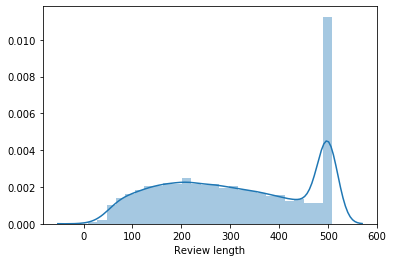

In [12]:
sns.distplot(df1['Review length'])

In [13]:
def mark_counter(string):
    counter = 0
    for i in string:
        if i == '!':
            counter += 1
    return counter

In [14]:
df1['Exc count'] = df1['Review Text'].apply(mark_counter)

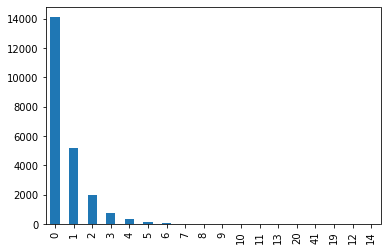

In [15]:
df1['Exc count'].value_counts().plot(kind='bar')

In [16]:
def depunctuate(text):
    clean_list = []
    for i in text:
        if i not in string.punctuation:
            clean_list.append(i)
    clean_text = ''.join(clean_list)
    return clean_text
    

In [17]:
df1['depunct_Review'] = df1['Review Text'].apply(depunctuate)

In [18]:
df1.head() #We can see that all the punctuations have been removed from our reviews

,Review Text,Recommended IND,Review length,Exc count,depunct_Review
0,Absolutely wonderful - silky and sexy and comf...,1,53,0,Absolutely wonderful silky and sexy and comfo...
1,Love this dress! it's sooo pretty. i happene...,1,303,1,Love this dress its sooo pretty i happened t...
2,I had such high hopes for this dress and reall...,0,500,1,I had such high hopes for this dress and reall...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124,2,I love love love this jumpsuit its fun flirty ...
4,This shirt is very flattering to all due to th...,1,192,3,This shirt is very flattering to all due to th...


In [19]:
def pos_collector(string):
    new_string = []
    review_string = word_tokenize(string)
    pos_word = nltk.pos_tag(review_string) #pos_tag method returns list of tuples containing token and related POS tag
    for i in pos_word:
        if i[1] in ('JJ','JJR','JJS','VB','VBD','VBG','NN'):
            new_string.append(i[0])
    return ' '.join(new_string)


In [21]:
df1['pos_Review'] = df1['depunct_Review'].apply(pos_collector)

In [22]:
df1.head()

,Review Text,Recommended IND,Review length,Exc count,depunct_Review,pos_Review
0,Absolutely wonderful - silky and sexy and comf...,1,53,0,Absolutely wonderful silky and sexy and comfo...,wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,1,303,1,Love this dress its sooo pretty i happened t...,Love dress sooo pretty i happened find store i...
2,I had such high hopes for this dress and reall...,0,500,1,I had such high hopes for this dress and reall...,had such high dress wanted work petite small u...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124,2,I love love love this jumpsuit its fun flirty ...,love jumpsuit fun flirty fabulous time i i not...
4,This shirt is very flattering to all due to th...,1,192,3,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...


In [25]:
stop_words = nltk.corpus.stopwords.words('english')

In [26]:
len(stop_words)

179

In [11]:
X = df1['Review Text']
y = df1['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [12]:
count_vec = CountVectorizer()
Xtrain_counts = count_vec.fit_transform(X_train)
Xtrain_counts #14145 number of unique words in our corpus

<15848x12200 sparse matrix of type '<class 'numpy.int64'>'
	with 678966 stored elements in Compressed Sparse Row format>

In [13]:

tfidf_trans = TfidfTransformer()
Xtrain_tfidf = tfidf_trans.fit_transform(Xtrain_counts)

In [14]:
#TfidfVectorizer does both CountVectorizer and TfidfTransformer in one function
txt_clf = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())]) #Applying a basic SVC algorithm as a benchmark model to beat

In [15]:
txt_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [16]:
ypred = txt_clf.predict(X_test)

In [17]:
print(confusion_matrix(y_test, ypred))

[[ 778  469]
 [ 265 5281]]


In [18]:
print(classification_report(y_test,ypred))

precision    recall  f1-score   support

           0       0.75      0.62      0.68      1247
           1       0.92      0.95      0.94      5546

    accuracy                           0.89      6793
   macro avg       0.83      0.79      0.81      6793
weighted avg       0.89      0.89      0.89      6793

